In [122]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

from time import time
from datetime import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
import xgboost as xgb

In [3]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

In [3]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [4]:
test.head(2)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402


In [5]:
train = train.drop('id', axis=1)

In [6]:
len(train.loc[:,'sat_id'].unique())

600

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649912 entries, 0 to 649911
Data columns (total 14 columns):
epoch     649912 non-null object
sat_id    649912 non-null int64
x         649912 non-null float64
y         649912 non-null float64
z         649912 non-null float64
Vx        649912 non-null float64
Vy        649912 non-null float64
Vz        649912 non-null float64
x_sim     649912 non-null float64
y_sim     649912 non-null float64
z_sim     649912 non-null float64
Vx_sim    649912 non-null float64
Vy_sim    649912 non-null float64
Vz_sim    649912 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 69.4+ MB


In [8]:
train.describe()

,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
count,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000
mean,308.730351,-817.243624,423.039342,-75.033412,-0.000571,0.000468,-0.000084,-949.710660,324.557198,-79.766677,-0.000519,0.000394,-0.000312
std,171.482926,25391.507810,25631.511540,20652.050496,2.639041,2.597130,2.116245,25374.076264,25607.472371,20667.988715,2.637491,2.600323,2.113769
min,0.000000,-251938.766780,-291083.016974,-178922.412426,-8.286673,-8.231654,-9.371164,-255037.952966,-282851.387908,-180250.922287,-8.243159,-8.348831,-7.671565
25%,166.000000,-13127.557237,-11620.365836,-8000.289962,-1.892727,-1.874982,-1.255991,-13153.145398,-11736.509125,-7956.446370,-1.896259,-1.877142,-1.246751
50%,312.000000,-506.673520,514.039628,45.175018,0.019951,-0.051700,0.009385,-623.114440,523.437227,56.891526,0.021274,-0.012901,0.012037
75%,461.000000,11318.543144,12614.274408,8279.083423,1.960031,1.845111,1.237103,11190.022140,12547.532119,8235.078108,1.955522,1.862365,1.236030
max,599.000000,200382.689756,212443.393808,197200.530574,8.149559,12.308450,8.644558,200961.158000,209619.553857,198526.091552,7.431851,8.021438,8.644165


In [9]:
train.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [112]:
train_real = train.loc[:, ['epoch','sat_id','x','y','z','Vx','Vy','Vz']]
train_sim = train.loc[:, ['epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

In [113]:
print(train_real.columns)
print(train_sim.columns)

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz'], dtype='object')
Index(['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim'],
      dtype='object')


## Попробуем посмтроить графики координат для реал и предиктов 

![title](coordinates.png)

In [114]:
coord_real = train_real[train_real['sat_id'] == 0].loc[:, ['x','y','z']]
coord_sim = train_sim[train_sim['sat_id'] == 0].loc[:, ['x_sim','y_sim','z_sim']]

In [115]:
print('observ number:', train_real[train_real['sat_id'] == 0].shape[0])

observ number: 958


(-50000, 50000)

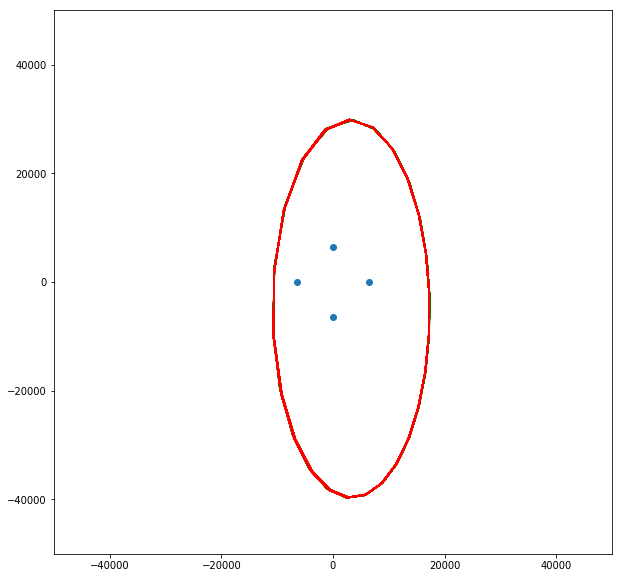

In [138]:
ax = plt.figure(figsize=(10,10))
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'y'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'y_sim'], 'r')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

(-50000, 50000)

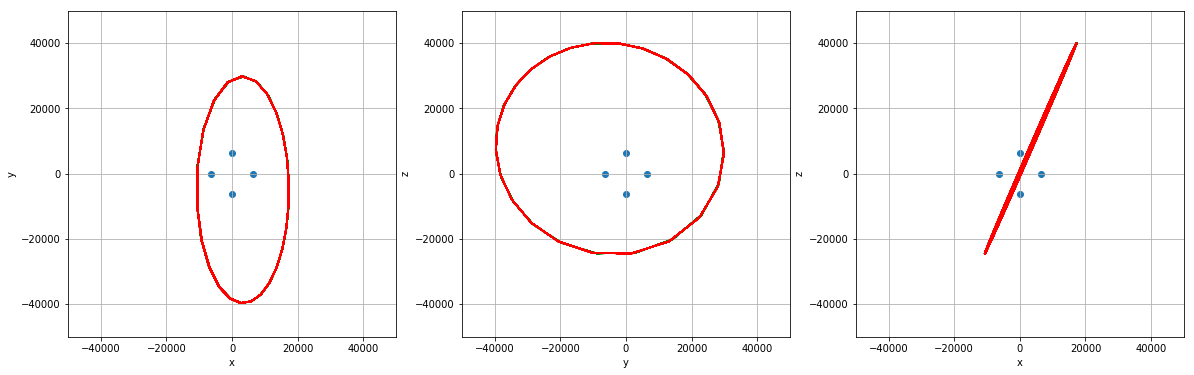

In [146]:
# plot example
# точками обозначена Земля
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(131)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'y'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'y_sim'], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'y'], coord_real.loc[:,'z'], 'g')
plt.plot(coord_sim.loc[:,'y_sim'], coord_sim.loc[:,'z_sim'], 'r')
plt.xlabel('y')
plt.ylabel('z')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
plt.grid()
plt.scatter([-6371,6371,0,0], [0,0,-6371,6371])
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'z'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'z_sim'], 'r')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim(-50000, 50000)
plt.ylim(-50000, 50000)

Если присмотреться, то видно, что предикты смещены

In [15]:
diff = pd.DataFrame({'x':np.subtract(coord_real.loc[:,'x'],coord_sim.loc[:,'x_sim']),
                     'y':np.subtract(coord_real.loc[:,'y'],coord_sim.loc[:,'y_sim']),
                     'z':np.subtract(coord_real.loc[:,'z'],coord_sim.loc[:,'z_sim'])})

In [16]:
diff.head(5)

,x,y,z
0,-12.692409,-20.441543,13.262073
1,-12.172318,-29.543301,21.276285
2,-6.825572,-34.527552,32.888826
3,1.368937,-33.237259,44.637815
4,10.266521,-26.790192,53.492019


In [17]:
diff = np.abs(diff)
diff.head()

,x,y,z
0,12.692409,20.441543,13.262073
1,12.172318,29.543301,21.276285
2,6.825572,34.527552,32.888826
3,1.368937,33.237259,44.637815
4,10.266521,26.790192,53.492019


In [18]:
diff.tail()

,x,y,z
953,1911.918388,15612.075013,4879.299912
954,3429.845937,14789.698343,8355.689969
955,5005.320639,13066.730924,11936.165799
956,6572.080659,10195.884818,15459.066758
957,7990.429369,5889.747366,18591.737280


In [19]:
diff.describe()

,x,y,z
count,958.000000,958.000000,958.000000
mean,2195.813550,5436.462537,5065.499649
std,2120.704688,5305.448932,4900.420056
min,0.935108,0.019449,0.144493
25%,71.485954,198.433841,121.724188
50%,1918.363332,5037.648279,4222.863670
75%,3456.898622,7988.854995,8018.753990
max,9158.649797,24606.996844,20854.343912


Если учесть, что значения координат могут варьироваться от -250000 до + 200000, то норм

## Исправление ошибки SGP4 

In [3]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

# train_real = train.loc[:, ['id', 'epoch','sat_id','x','y','z','Vx','Vy','Vz']]
# train_sim = train.loc[:, ['id', 'epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

In [4]:
print(train.shape)
print(test.shape)
# print(train_real.shape)
# print(train_sim.shape)

(649912, 15)
(284071, 9)


#### Перевод эпохи в столбцы день, час, минут, секунд

Время наблюдений у нас только Январь 2014 года => изменения года, месяца не влияют

In [5]:
min(train.loc[:,'epoch'])

'2014-01-01T00:00:00.000'

In [6]:
max(train.loc[:,'epoch'])

'2014-01-31T23:59:59.991'

In [7]:
train.loc[0:2,'epoch']

0    2014-01-01T00:00:00.000
1    2014-01-01T00:46:43.000
2    2014-01-01T01:33:26.001
Name: epoch, dtype: object

In [8]:
print(train.loc[0,'epoch'])
print(type(train.loc[0,'epoch']))

2014-01-01T00:00:00.000
<class 'str'>


Раз это стринги, при этом все одного формата, то тупо заслайсим их

In [9]:
train['day'] = train.loc[:,'epoch'].str.slice(start=8, stop=10).astype('int32')-1
train['hour'] = train.loc[:,'epoch'].str.slice(start=11, stop=13).astype('int32')
train['minute'] = train.loc[:,'epoch'].str.slice(start=14, stop=16).astype('int32')
train['second'] = train.loc[:,'epoch'].str.slice(start=17, stop=19).astype('int32')

In [10]:
test['day'] = test.loc[:,'epoch'].str.slice(start=8, stop=10).astype('int32')-1
test['hour'] = test.loc[:,'epoch'].str.slice(start=11, stop=13).astype('int32')
test['minute'] = test.loc[:,'epoch'].str.slice(start=14, stop=16).astype('int32')
test['second'] = test.loc[:,'epoch'].str.slice(start=17, stop=19).astype('int32')

In [11]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0,0,0,0
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0,0,46,43
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0,1,33,26


#### Сделаем столбец кол-во секунд с начала наблюдений

Как видно все спутники наблюдаются с 2014-01-01T00:00:00.000

In [12]:
max(train.groupby('sat_id', as_index=False).min().loc[:,'epoch'])

'2014-01-01T00:00:00.000'

In [13]:
train['passed_seconds'] = train.loc[:,'second'] + train.loc[:,'minute']*60 + train.loc[:,'hour']*60*60 + train.loc[:,'day']*60*60*24

In [14]:
test['passed_seconds'] = test.loc[:,'second'] + test.loc[:,'minute']*60 + test.loc[:,'hour']*60*60 + test.loc[:,'day']*60*60*24

In [15]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0,0,0,0,0
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0,0,46,43,2803
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0,1,33,26,5606


#### Перевод координат в точки 

Пока посчитаем пройденный путь без учета сферичности Земли (по прямой)

In [20]:
train['path'] = np.sqrt(np.power(train.loc[:, 'x'],2) + 
                             np.power(train.loc[:, 'y'],2) + 
                             np.power(train.loc[:, 'z'],2)) 

In [21]:
train['path_sim'] = np.sqrt(np.power(train.loc[:, 'x_sim'],2) + 
                            np.power(train.loc[:, 'y_sim'],2) + 
                            np.power(train.loc[:, 'z_sim'],2)) 

In [22]:
test['path_sim'] = np.sqrt(np.power(test.loc[:, 'x_sim'],2) + 
                            np.power(test.loc[:, 'y_sim'],2) + 
                            np.power(test.loc[:, 'z_sim'],2)) 

In [23]:
train.head(2)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds,path,path_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,-0.907527,-3.804930,-2.024133,0,0,0,0,0,26080.000000,26096.521772
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,...,-0.303704,-4.269816,-0.616468,0,0,46,43,2803,26686.896582,26703.386480


Посмотрим увеличивается ли дельта между реальными и симул. данными

In [24]:
# размер ошибки
def plot_coord_dif(n):
    coord_dif = train[train['sat_id'] == n].loc[:, 'path'] - train[train['sat_id'] == n].loc[:, 'path_sim']
    coord_range = train[train['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))

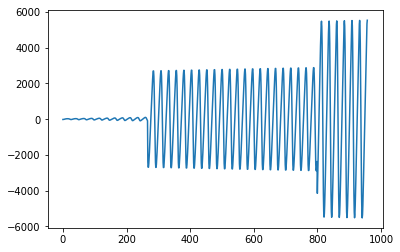

In [25]:
plot_coord_dif(0)

In [26]:
# размер ошибки по дельте времени
def plot_coord_dif_time(n):
    coord_dif = train[train['sat_id'] == n].loc[:, 'path'] - train[train['sat_id'] == n].loc[:, 'path_sim']
    passed_seconds = train[train['sat_id'] == n].loc[:, 'passed_seconds']
    plt.plot(passed_seconds, np.array(coord_dif))

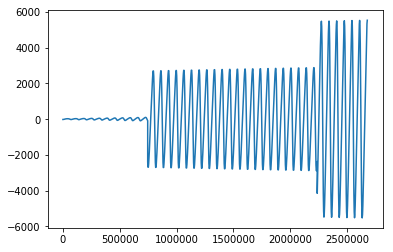

In [27]:
plot_coord_dif_time(0)

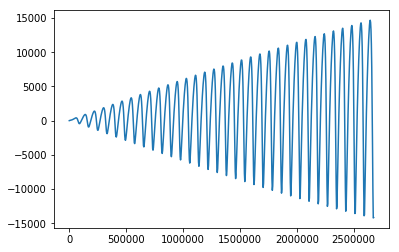

In [28]:
plot_coord_dif_time(333)

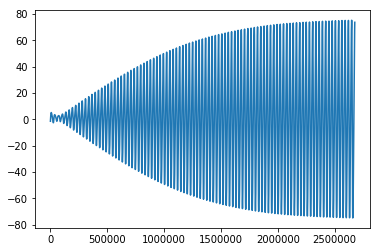

In [29]:
plot_coord_dif_time(444)

#### Стабильна ли скорость во времени 

In [30]:
train['V'] = np.sqrt(np.power(train.loc[:, 'Vx'],2) + 
                     np.power(train.loc[:, 'Vy'],2) + 
                     np.power(train.loc[:, 'Vz'],2)) 

In [31]:
train['V_sim'] = np.sqrt(np.power(train.loc[:, 'Vx_sim'],2) + 
                         np.power(train.loc[:, 'Vy_sim'],2) + 
                         np.power(train.loc[:, 'Vz_sim'],2)) 

In [32]:
test['V_sim'] = np.sqrt(np.power(test.loc[:, 'Vx_sim'],2) + 
                         np.power(test.loc[:, 'Vy_sim'],2) + 
                         np.power(test.loc[:, 'Vz_sim'],2)) 

In [33]:
train.loc[:, ['epoch','sat_id','V']].head(10)

,epoch,sat_id,V
0,2014-01-01T00:00:00.000,0,4.406588
1,2014-01-01T00:46:43.000,0,4.326931
2,2014-01-01T01:33:26.001,0,4.120966
3,2014-01-01T02:20:09.001,0,3.854871
4,2014-01-01T03:06:52.002,0,3.582143
5,2014-01-01T03:53:35.002,0,3.331210
6,2014-01-01T04:40:18.003,0,3.113272
7,2014-01-01T05:27:01.003,0,2.931178
8,2014-01-01T06:13:44.004,0,2.784557
9,2014-01-01T07:00:27.004,0,2.672147


In [34]:
train.loc[:, ['epoch','sat_id','V_sim']].head(10)

,epoch,sat_id,V_sim
0,2014-01-01T00:00:00.000,0,4.404340
1,2014-01-01T00:46:43.000,0,4.324766
2,2014-01-01T01:33:26.001,0,4.119305
3,2014-01-01T02:20:09.001,0,3.853846
4,2014-01-01T03:06:52.002,0,3.581697
5,2014-01-01T03:53:35.002,0,3.331236
6,2014-01-01T04:40:18.003,0,3.113676
7,2014-01-01T05:27:01.003,0,2.931893
8,2014-01-01T06:13:44.004,0,2.785534
9,2014-01-01T07:00:27.004,0,2.673353


In [35]:
def plot_V(n):
    plt.plot(list(train[train['sat_id'] == n].index), list(train[train['sat_id'] == n].loc[:,'V']))

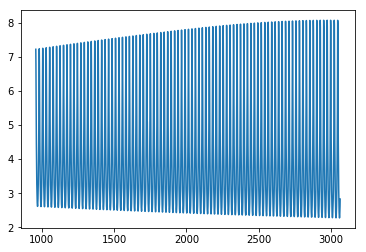

In [36]:
plot_V(1)

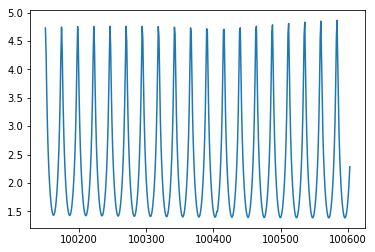

In [37]:
plot_V(100)

#### Признаки - прирост координат от скоростей по осям (Vx^2 / (Vx^2 + Vy^2 + Vz^2 )

In [38]:
train['Vx_gain'] = np.power(train.loc[:, 'Vx'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))
train['Vy_gain'] = np.power(train.loc[:, 'Vy'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))
train['Vz_gain'] = np.power(train.loc[:, 'Vz'],2) / (np.power(train.loc[:, 'Vx'],2) + np.power(train.loc[:, 'Vy'],2) + np.power(train.loc[:, 'Vz'],2))

In [39]:
train['Vx_sim_gain'] = np.power(train.loc[:, 'Vx_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))
train['Vy_sim_gain'] = np.power(train.loc[:, 'Vy_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))
train['Vz_sim_gain'] = np.power(train.loc[:, 'Vz_sim'],2) / (np.power(train.loc[:, 'Vx_sim'],2) + np.power(train.loc[:, 'Vy_sim'],2) + np.power(train.loc[:, 'Vz_sim'],2))

In [40]:
test['Vx_sim_gain'] = np.power(test.loc[:, 'Vx_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))
test['Vy_sim_gain'] = np.power(test.loc[:, 'Vy_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))
test['Vz_sim_gain'] = np.power(test.loc[:, 'Vz_sim'],2) / (np.power(test.loc[:, 'Vx_sim'],2) + np.power(test.loc[:, 'Vy_sim'],2) + np.power(test.loc[:, 'Vz_sim'],2))

In [41]:
train.loc[:, ['Vx', 'Vy', 'Vz', 'Vx_gain', 'Vy_gain', 'Vz_gain']].head()

,Vx,Vy,Vz,Vx_gain,Vy_gain,Vz_gain
0,-0.908303,-3.808436,-2.022083,0.042487,0.746945,0.210568
1,-0.302590,-4.272617,-0.612796,0.004890,0.975052,0.020057
2,0.277435,-4.047522,0.723155,0.004532,0.964674,0.030794
3,0.715600,-3.373762,1.722115,0.034460,0.765965,0.199574
4,0.992507,-2.519732,2.344703,0.076768,0.494792,0.428440


#### Признаки - эллиптичность орбиты

Эллиптичность рассчитывается как e = sqrt(pow(a,2)-pow(b,2)) / a

"a" - большая полуось; "b" - малая полуось; "е" - эксцентриситет эллипса

In [99]:
sat_data = pd.DataFrame(train.loc[:,'sat_id'].unique(), columns=['sat_id'])

In [101]:
sat_data.head(3)

,sat_id
0,0
1,1
2,2


In [106]:
sat_data['x_sim_max'] = train.loc[:, ['sat_id', 'x_sim']].groupby('sat_id').max()
sat_data['x_sim_min'] = train.loc[:, ['sat_id', 'x_sim']].groupby('sat_id').min()
sat_data['y_sim_max'] = train.loc[:, ['sat_id', 'y_sim']].groupby('sat_id').max()
sat_data['y_sim_min'] = train.loc[:, ['sat_id', 'y_sim']].groupby('sat_id').min()
sat_data['z_sim_max'] = train.loc[:, ['sat_id', 'z_sim']].groupby('sat_id').max()
sat_data['z_sim_min'] = train.loc[:, ['sat_id', 'z_sim']].groupby('sat_id').min()

In [107]:
sat_data.head(3)

,sat_id,x_sim_max,x_sim_min,y_sim_max,y_sim_min,z_sim_max,z_sim_min
0,0,17269.627379,-10663.078739,29891.530302,-39691.962101,40044.763219,-24477.716135
1,1,11199.853336,-30287.447717,19114.979309,-14496.096094,7119.621702,-12220.661191
2,2,34479.954736,-83304.837665,57453.564201,-36319.224115,36978.913464,-35513.924909


In [109]:
sat_data['x_sim_varience'] = sat_data.loc[:,'x_sim_max'] - sat_data.loc[:,'x_sim_min']
sat_data['y_sim_varience'] = sat_data.loc[:,'y_sim_max'] - sat_data.loc[:,'y_sim_min']
sat_data['z_sim_varience'] = sat_data.loc[:,'z_sim_max'] - sat_data.loc[:,'z_sim_min']

In [110]:
sat_data.head(3)

,sat_id,x_sim_max,x_sim_min,y_sim_max,y_sim_min,z_sim_max,z_sim_min,x_sim_varience,y_sim_varience,z_sim_varience
0,0,17269.627379,-10663.078739,29891.530302,-39691.962101,40044.763219,-24477.716135,27932.706118,69583.492403,64522.479354
1,1,11199.853336,-30287.447717,19114.979309,-14496.096094,7119.621702,-12220.661191,41487.301053,33611.075402,19340.282892
2,2,34479.954736,-83304.837665,57453.564201,-36319.224115,36978.913464,-35513.924909,117784.792401,93772.788316,72492.838373


#### Ошибка по координатам от скорости

In [33]:
train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds,x_dif,path,path_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,-3.80493,-2.024133,0,0,0,0,0,-12.692409,26080.0,26096.521772


In [35]:
train['x_dif'] = train.loc[:, 'x'] - train.loc[:, 'x_sim']
train['y_dif'] = train.loc[:, 'y'] - train.loc[:, 'y_sim']
train['z_dif'] = train.loc[:, 'z'] - train.loc[:, 'z_sim']

train['Vx_dif'] = train.loc[:, 'Vx'] - train.loc[:, 'Vx_sim']
train['Vy_dif'] = train.loc[:, 'Vy'] - train.loc[:, 'Vy_sim']
train['Vz_dif'] = train.loc[:, 'Vz'] - train.loc[:, 'Vz_sim']

train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,...,second,passed_seconds,path,path_sim,x_dif,y_dif,z_dif,Vx_dif,Vy_dif,Vz_dif
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,...,0,0,26080.0,26096.521772,-12.692409,-20.441543,13.262073,-0.000776,-0.003506,0.00205


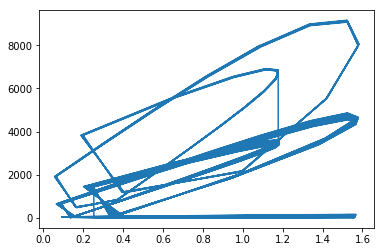

In [39]:
plt.plot(np.abs(train[train['sat_id']==0].loc[:, 'Vx']), np.abs(train[train['sat_id']==0].loc[:, 'x_dif']))

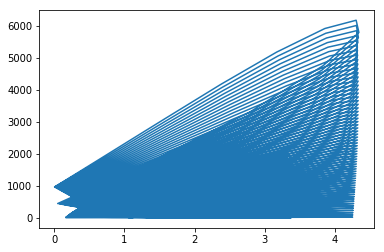

In [41]:
plt.plot(np.abs(train[train['sat_id']==111].loc[:, 'Vx']), np.abs(train[train['sat_id']==111].loc[:, 'x_dif']))

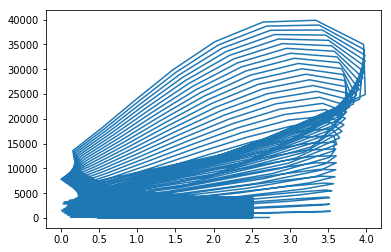

In [42]:
plt.plot(np.abs(train[train['sat_id']==333].loc[:, 'Vx']), np.abs(train[train['sat_id']==333].loc[:, 'x_dif']))

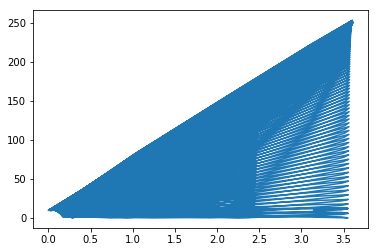

In [43]:
plt.plot(np.abs(train[train['sat_id']==444].loc[:, 'Vx']), np.abs(train[train['sat_id']==444].loc[:, 'x_dif']))

In [44]:
linear = range(10)
nonlinear = [x ** 2 for x in range(10)]

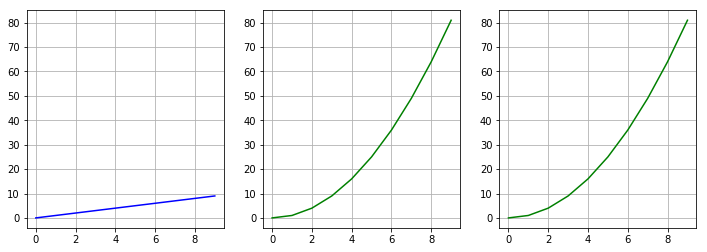

In [64]:
# plot example
plt.figure(figsize=(12, 4))

ax1 = plt.subplot(131)
plt.grid()
plt.plot(linear, 'b-')

ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
plt.grid()
plt.plot(nonlinear, 'g-')

ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
plt.grid()
plt.plot(nonlinear, 'g-')

## Если дороги ваши нервы, то дальше лучше не смотреть 

### Линейная модель 

In [23]:
y_train, y_test, X_train, X_test  = train_test_split(train_real.drop([ 'epoch', 'sat_id'], axis=1), 
                                                    train_sim.drop([ 'epoch', 'sat_id'], axis=1),
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

переставлены y, Х, чтобы в у были реальные значения

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454938, 7)
(454938, 12)
(194974, 7)
(194974, 12)


In [23]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_lin_train =  model_lin.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred train: 3365.99976533023
MAE pred: 3332.031462084599
MAE sim: 3089.196364769518


Вышло хуже симуляции, попробуем по-фану докинуть координаты другие и спиды :))) по осям

In [27]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim']], np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim']])

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred: 3389.831680769296
MAE sim: 3089.196364769518


Еще хуже

Соберем сабамит из линейных моделей, чтобы сравнить с sample submission

In [60]:
# train_real = train_real.drop([ 'epoch', 'sat_id'], axis=1) 
# train_sim = train_sim.drop([ 'epoch', 'sat_id'], axis=1)

In [61]:
# model_lin = LinearRegression()

# model_lin.fit(np.array(train_sim.loc[:, 'x_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'x']))
# pred_x = model_lin.predict(np.array(test.loc[:, 'x_sim']).reshape(-1, 1))               

In [62]:
# model_lin.fit(np.array(train_sim.loc[:, 'y_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'y']))
# pred_y = model_lin.predict(np.array(test.loc[:, 'y_sim']).reshape(-1, 1))     

In [63]:
# model_lin.fit(np.array(train_sim.loc[:, 'z_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'z']))
# pred_z = model_lin.predict(np.array(test.loc[:, 'z_sim']).reshape(-1, 1))    

In [64]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vx_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vx']))
# pred_Vx = model_lin.predict(np.array(test.loc[:, 'Vx_sim']).reshape(-1, 1))    

In [65]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vy_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vy']))
# pred_Vy = model_lin.predict(np.array(test.loc[:, 'Vy_sim']).reshape(-1, 1))     

In [66]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vz_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vz']))
# pred_Vz = model_lin.predict(np.array(test.loc[:, 'Vz_sim']).reshape(-1, 1))    

In [67]:
# submission_linear = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [68]:
# submission_linear.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_linear.csv', index=False)

Score :65.1 (baseline: 66.24)

In [109]:
model_lin.fit(train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']], train.loc[:,'x'])
pred_x = model_lin.predict(test.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])

In [110]:
model_lin.fit(train.loc[:,['y_sim', 'passed_seconds', 'Vy_sim_gain']], train.loc[:,'y'])
pred_y = model_lin.predict(test.loc[:,['y_sim', 'passed_seconds', 'Vy_sim_gain']])

In [111]:
model_lin.fit(train.loc[:,['z_sim', 'passed_seconds', 'Vz_sim_gain']], train.loc[:,'z'])
pred_z = model_lin.predict(test.loc[:,['z_sim', 'passed_seconds', 'Vz_sim_gain']])

In [112]:
model_lin.fit(train.loc[:,['Vx_sim', 'passed_seconds', 'Vx_sim_gain']], train.loc[:,'Vx'])
pred_Vx = model_lin.predict(test.loc[:,['Vx_sim', 'passed_seconds', 'Vx_sim_gain']])

In [113]:
model_lin.fit(train.loc[:,['Vy_sim', 'passed_seconds', 'Vy_sim_gain']], train.loc[:,'Vy'])
pred_Vy = model_lin.predict(test.loc[:,['Vy_sim', 'passed_seconds', 'Vy_sim_gain']])

In [114]:
model_lin.fit(train.loc[:,['Vz_sim', 'passed_seconds', 'Vz_sim_gain']], train.loc[:,'Vz'])
pred_Vz = model_lin.predict(test.loc[:,['Vz_sim', 'passed_seconds', 'Vz_sim_gain']])

In [115]:
submission_linear = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [116]:
submission_linear.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_linear_shuffle_by_id.csv', index=False)

Score :65.1 (baseline: 66.24)

### XGBRegression 

In [73]:
# model = xgb.XGBRegressor(booster='gblinear',
#                  colsample_bytree=0.4,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=3,
#                  n_estimators=10000,                                                                    
#                  reg_alpha=0.75,
#                  reg_lambda=0.45,
#                  seed=1)

In [79]:
model = xgb.XGBRegressor(booster='gblinear')

model.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_xgb = model.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))
pred_xgb_train = model.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_xgb_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_xgb))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

[18:10:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE pred train: 3366.2250638530472
MAE pred: 3332.2582908570134
MAE sim: 3089.196364769518


Почти то же самое, что и LinearRegression

#### Попробуем теперь линейную модель

In [16]:
y_train, y_test, X_train, X_test  = train_test_split(train.loc[:,['x','y','z','Vx','Vy','Vz']], 
                                                    train.loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds']],
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454938, 7)
(454938, 6)
(194974, 7)
(194974, 6)


In [17]:
train.head(1)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,day,hour,minute,second,passed_seconds
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.22169,-20741.615306,-0.907527,-3.80493,-2.024133,0,0,0,0,0


In [18]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 3365.7655160420095
MAE pred: 3331.52467359851
MAE sim: 3089.196364769518


ШтоШ, ничто не маешает затестить и свой монструозный ГБ

In [19]:
model_lin = GradientBoostingRegressor(learning_rate=0.3, n_estimators=500)

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

MAE pred train: 3330.1349003570654
MAE pred: 3374.185611458891
MAE sim: 3089.196364769518


Ничего не изменилось

Опять посмотрим на результат

In [42]:
train.columns

Index(['id', 'epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim',
       'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim', 'day', 'hour', 'minute',
       'second', 'passed_seconds', 'path', 'path_sim', 'V', 'V_sim', 'Vx_gain',
       'Vy_gain', 'Vz_gain', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain'],
      dtype='object')

In [43]:
y_train, y_test, X_train, X_test  = train_test_split(train.loc[:,['x','y','z','Vx','Vy','Vz', 'Vx_gain', 'Vy_gain', 'Vz_gain']], 
                                                    train.loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']],
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(454938, 10)
(454938, 9)
(194974, 10)
(194974, 9)
MAE pred train: 3365.7952404783846
MAE pred: 3331.537047490868
MAE sim: 3089.196364769518


Попробуем разбить без шаффла на отдельные спутники

In [90]:
ids = np.arange(0,600,1)
np.random.seed(1)
np.random.shuffle(ids)
train_ids, test_ids = ids[:500], ids[500:601]

y_train = train[train.loc[:,'sat_id'].isin(train_ids)].loc[:,['x','y','z','Vx','Vy','Vz']]
y_test =  train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,['x','y','z','Vx','Vy','Vz']] 
X_train = train[train.loc[:,'sat_id'].isin(train_ids)].loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']]
X_test =  train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(541958, 10)
(541958, 6)
(107954, 10)
(107954, 6)
MAE pred train: 3274.6376721943166
MAE pred: 3568.3772117428703
MAE sim: 3359.827842431769


СВМ SVR - плохой результат

In [66]:
scaler = preprocessing.StandardScaler()
train_tmp = train.drop(['id', 'epoch', 'sat_id'], axis=1)
test_tmp = test.drop(['id', 'epoch', 'sat_id'], axis=1)
train_tmp = pd.DataFrame(scaler.fit_transform(train_tmp), columns = train_tmp.columns)
test_tmp = pd.DataFrame(scaler.fit_transform(test_tmp),  columns = test_tmp.columns)

train_tmp = pd.concat([train.loc[:,'sat_id'], train_tmp], axis=1)
test_tmp =  pd.concat([test.loc[:,'sat_id'], test_tmp], axis=1)

ids = np.arange(0,600,1)
np.random.seed(1)
np.random.shuffle(ids)
train_ids, test_ids = ids[:500], ids[500:601]

y_train = train_tmp[train_tmp.loc[:,'sat_id'].isin(train_ids)].loc[:,['x','y','z','Vx','Vy','Vz']]
y_test =  train_tmp[train_tmp.loc[:,'sat_id'].isin(test_ids)].loc[:,['x','y','z','Vx','Vy','Vz']] 
X_train = train_tmp[train_tmp.loc[:,'sat_id'].isin(train_ids)].loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']]
X_test =  train_tmp[train_tmp.loc[:,'sat_id'].isin(test_ids)].loc[:,['x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim','passed_seconds', 'Vx_sim_gain', 'Vy_sim_gain', 'Vz_sim_gain']]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model_lin = LinearSVR(random_state=1, max_iter=2000)

model_lin.fit(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']], y_train.loc[:,'x'])

pred_lin_train =  model_lin.predict(X_train.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])
pred_lin = model_lin.predict(X_test.loc[:,['x_sim', 'passed_seconds', 'Vx_sim_gain']])

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim'])))

(541958, 10)
(541958, 6)
(107954, 10)
(107954, 6)
MAE pred train: 0.12067941721025789
MAE pred: 0.13234090403423662
MAE sim: 0.1330100814888459


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']

8996      24439.156915
8997      36903.361280
8998      25330.707700
8999       7902.859437
9000     -10461.647376
              ...     
645009    -3321.024652
645010   -10325.340908
645011   -16807.962442
645012   -22523.061314
645013   -27288.711363
Name: x, Length: 107954, dtype: float64

In [72]:
scaler.fit_transform(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']).reshape(-1, 1))

array([[ 0.97525236],
       [ 1.46021104],
       [ 1.00994092],
       ...,
       [-0.62959526],
       [-0.85195897],
       [-1.03738143]])

In [80]:
pred_lin[:5]

array([ 1.10527158,  1.47338138,  0.99192614,  0.30860355, -0.40581497])

In [83]:
pred_lin_unscaled = scaler.inverse_transform(pred_lin)
pred_lin_unscaled[:5]

array([ 27780.85638319,  37241.85978655,  24867.69947107,   7305.22920038,
       -11056.45547719])

In [91]:
pd.Series(pred_lin_unscaled)

0         27780.856383
1         37241.859787
2         24867.699471
3          7305.229200
4        -11056.455477
              ...     
107949    -1970.782980
107950    -9101.505301
107951   -15752.932606
107952   -21665.722426
107953   -26649.566613
Length: 107954, dtype: float64

In [88]:
print('MAE pred:', mean_absolute_error(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']), pred_lin_unscaled))
print('MAE pred:', mean_absolute_error(np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']), np.array(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim'])))

MAE pred: 3433.9626889392957
MAE pred: 3359.827842431769


In [89]:
print('MAE pred:', mean_absolute_error(np.array(train.loc[:,'x']), np.array(train.loc[:,'x_sim'])))

MAE pred: 3113.873308007775


In [95]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x']

8996      24439.156915
8997      36903.361280
8998      25330.707700
8999       7902.859437
9000     -10461.647376
              ...     
645009    -3321.024652
645010   -10325.340908
645011   -16807.962442
645012   -22523.061314
645013   -27288.711363
Name: x, Length: 107954, dtype: float64

In [96]:
train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim']

8996      27274.647776
8997      36625.418859
8998      24388.765323
8999       7017.252693
9000     -11147.186870
              ...     
645009    -2097.226576
645010    -9154.093490
645011   -15741.136438
645012   -21600.522604
645013   -26542.296616
Name: x_sim, Length: 107954, dtype: float64

In [94]:
pd.Series(pred_lin_unscaled)

0         27780.856383
1         37241.859787
2         24867.699471
3          7305.229200
4        -11056.455477
              ...     
107949    -1970.782980
107950    -9101.505301
107951   -15752.932606
107952   -21665.722426
107953   -26649.566613
Length: 107954, dtype: float64

In [97]:
np.sum(np.abs(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x'] - train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x_sim']))

362706854.9018792

In [98]:
np.sum(np.abs(train[train.loc[:,'sat_id'].isin(test_ids)].loc[:,'x'] - pd.Series(pred_lin_unscaled)))

343276926.0496332